# Regression
Predict the final goals scored per each team.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
pd.set_option('display.max_columns', 999)

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.estimator import inputs
from tensorflow import feature_column
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import load_model


import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

from  IPython import display
from matplotlib import pyplot as plt

import numpy as np
import math

import pathlib
import shutil
import tempfile

tf.compat.v1.disable_eager_execution()

In [2]:
#pip install git+https://github.com/tensorflow/docs

## Data Preprocessing
    1. Normalization
    2. Data encoding: The goals [0,10] => [-1,1]. If Goal > 10 => 1

In [3]:
df02 = pd.read_csv('https://raw.githubusercontent.com/Khaledjallouli/project/master/data/data_regression_goals/sliding02_goals.csv', sep=',', index_col=0)

In [4]:
df02

,home_team_goal,away_team_goal,odds-home,odds-draw,odds-away,home-wins,home-draws,home-losses,home-goals,home-opposition-goals,home-shots,home-shots_on_target,home-opposition_shots,home-opposition_shots_on_target,away-wins,away-draws,away-losses,away-goals,away-opposition-goals,away-shots,away-shots_on_target,away-opposition_shots,away-opposition_shots_on_target
0,2,1,3.50,3.30,2.10,1,3,6,11,16,137,67,117,53,8,2,0,15,6,161,78,72,30
1,2,2,2.50,3.30,2.88,3,1,6,8,16,134,64,151,77,3,3,4,11,18,104,44,87,36
2,1,2,1.91,3.40,4.20,4,2,4,10,15,120,58,124,56,2,2,6,11,15,134,59,100,46
3,2,1,3.25,3.25,2.30,5,2,3,22,12,177,82,74,37,6,3,1,19,8,169,95,113,58
4,3,0,1.20,6.00,19.00,7,2,1,15,8,161,72,74,31,3,2,5,10,17,143,69,134,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7028,2,1,5.00,3.80,1.70,4,2,4,10,12,80,43,117,60,2,4,4,10,21,119,58,112,65
7029,4,2,2.00,3.60,3.70,3,2,5,9,21,89,47,92,46,1,4,5,7,21,104,55,63,26
7030,4,1,1.80,3.75,4.50,3,3,4,8,8,122,59,92,50,5,2,3,15,9,84,43,118,56
7031,3,1,1.33,5.25,9.00,2,3,5,12,14,124,62,99,50,3,3,4,11,17,103,53,122,54


In [5]:
byhomegoal = df02.groupby('home_team_goal')
byhomegoal.size().sort_values(ascending=False)

home_team_goal
1     2251
2     1732
0     1589
3      885
4      378
5      132
6       43
7       13
8        7
9        2
10       1
dtype: int64

In [6]:
byawaygoal = df02.groupby('away_team_goal')
byawaygoal.size().sort_values(ascending=False)

away_team_goal
1    2381
0    2362
2    1401
3     613
4     193
5      52
6      23
8       5
7       2
9       1
dtype: int64

### =>The two previous cells show that we can keep 6 classes: [0.5].


In [7]:
def get_X_and_y(dataframe):
    X = dataframe.drop(columns=['home_team_goal','away_team_goal']).values
    y = dataframe[['home_team_goal','away_team_goal']].values
    return X,y

In [8]:
def encode(i):
    switcher = {
        0: 0,
        1: 1,
        2: 2,
        3: 3,
        4: 4,
        5: 5,
    }
    # 1 be assigned as default value of passed argument (if goals > 5)
    #return switcher.get(i, 1)
    return switcher.get(i, 5)

def decode(i):
    switcher = {
        0: 0,
        1: 1,
        2: 2,
        3: 3,
        4: 4,
        5: 5,
    }
    #return switcher.get(i, "ERROR! Use Encode Before!")
    return switcher.get(i, "ERROR! Use Encode Before!")

In [11]:
def normalize_try(dataframe):
    highestValue = 0;
    ds = np.full((dataframe.shape[0], dataframe.shape[1]), 0)
    for i in range(dataframe.shape[0]):
        for j in range(dataframe.shape[1]):
            if highestValue < dataframe[i][j]:
                highestValue = dataframe[i][j]
    
    for i in range(dataframe.shape[0]):
        for j in range(dataframe.shape[1]):
                dataframe[i][j] = (dataframe[i][j]/highestValue)
    
    return dataframe

def normalize(dataframe):
    column_names_to_not_normalize = ['home_team_goal','away_team_goal']
    column_names_to_normalize = [x for x in list(dataframe) if x not in column_names_to_not_normalize ]
    x = dataframe[column_names_to_normalize].values
    #x_scaled = preprocessing.normalize(x)
    x_scaled = normalize_try(x)
    df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = dataframe.index)
    dataframe[column_names_to_normalize] = df_temp
    
    dataframe['home_team_goal'] = dataframe.apply(lambda row: encode(row['home_team_goal']), axis=1)
    dataframe['away_team_goal'] = dataframe.apply(lambda row: encode(row['away_team_goal']), axis=1)
    
    return dataframe

In [12]:
n02 = normalize(df02)

train02, test02 = train_test_split(n02, test_size=0.1, shuffle=False)
print(len(train02), 'train examples')
print(len(test02), 'test examples')

labels = n02.iloc[:,0:2]
train = n02.iloc[:,2:]


train_X02,train_y02 = get_X_and_y(train02)
labels_train = n02.iloc[:,0:2]

test_X02,test_y02 = get_X_and_y(test02)

6329 train examples
704 test examples


In [13]:
train

,odds-home,odds-draw,odds-away,home-wins,home-draws,home-losses,home-goals,home-opposition-goals,home-shots,home-shots_on_target,home-opposition_shots,home-opposition_shots_on_target,away-wins,away-draws,away-losses,away-goals,away-opposition-goals,away-shots,away-shots_on_target,away-opposition_shots,away-opposition_shots_on_target
0,0.015837,0.014932,0.009502,0.004525,0.013575,0.027149,0.049774,0.072398,0.619910,0.303167,0.529412,0.239819,0.036199,0.009050,0.000000,0.067873,0.027149,0.728507,0.352941,0.325792,0.135747
1,0.011312,0.014932,0.013032,0.013575,0.004525,0.027149,0.036199,0.072398,0.606335,0.289593,0.683258,0.348416,0.013575,0.013575,0.018100,0.049774,0.081448,0.470588,0.199095,0.393665,0.162896
2,0.008643,0.015385,0.019005,0.018100,0.009050,0.018100,0.045249,0.067873,0.542986,0.262443,0.561086,0.253394,0.009050,0.009050,0.027149,0.049774,0.067873,0.606335,0.266968,0.452489,0.208145
3,0.014706,0.014706,0.010407,0.022624,0.009050,0.013575,0.099548,0.054299,0.800905,0.371041,0.334842,0.167421,0.027149,0.013575,0.004525,0.085973,0.036199,0.764706,0.429864,0.511312,0.262443
4,0.005430,0.027149,0.085973,0.031674,0.009050,0.004525,0.067873,0.036199,0.728507,0.325792,0.334842,0.140271,0.013575,0.009050,0.022624,0.045249,0.076923,0.647059,0.312217,0.606335,0.312217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7028,0.022624,0.017195,0.007692,0.018100,0.009050,0.018100,0.045249,0.054299,0.361991,0.194570,0.529412,0.271493,0.009050,0.018100,0.018100,0.045249,0.095023,0.538462,0.262443,0.506787,0.294118
7029,0.009050,0.016290,0.016742,0.013575,0.009050,0.022624,0.040724,0.095023,0.402715,0.212670,0.416290,0.208145,0.004525,0.018100,0.022624,0.031674,0.095023,0.470588,0.248869,0.285068,0.117647
7030,0.008145,0.016968,0.020362,0.013575,0.013575,0.018100,0.036199,0.036199,0.552036,0.266968,0.416290,0.226244,0.022624,0.009050,0.013575,0.067873,0.040724,0.380090,0.194570,0.533937,0.253394
7031,0.006018,0.023756,0.040724,0.009050,0.013575,0.022624,0.054299,0.063348,0.561086,0.280543,0.447964,0.226244,0.013575,0.013575,0.018100,0.049774,0.076923,0.466063,0.239819,0.552036,0.244344


In [14]:
n02

,home_team_goal,away_team_goal,odds-home,odds-draw,odds-away,home-wins,home-draws,home-losses,home-goals,home-opposition-goals,home-shots,home-shots_on_target,home-opposition_shots,home-opposition_shots_on_target,away-wins,away-draws,away-losses,away-goals,away-opposition-goals,away-shots,away-shots_on_target,away-opposition_shots,away-opposition_shots_on_target
0,2,1,0.015837,0.014932,0.009502,0.004525,0.013575,0.027149,0.049774,0.072398,0.619910,0.303167,0.529412,0.239819,0.036199,0.009050,0.000000,0.067873,0.027149,0.728507,0.352941,0.325792,0.135747
1,2,2,0.011312,0.014932,0.013032,0.013575,0.004525,0.027149,0.036199,0.072398,0.606335,0.289593,0.683258,0.348416,0.013575,0.013575,0.018100,0.049774,0.081448,0.470588,0.199095,0.393665,0.162896
2,1,2,0.008643,0.015385,0.019005,0.018100,0.009050,0.018100,0.045249,0.067873,0.542986,0.262443,0.561086,0.253394,0.009050,0.009050,0.027149,0.049774,0.067873,0.606335,0.266968,0.452489,0.208145
3,2,1,0.014706,0.014706,0.010407,0.022624,0.009050,0.013575,0.099548,0.054299,0.800905,0.371041,0.334842,0.167421,0.027149,0.013575,0.004525,0.085973,0.036199,0.764706,0.429864,0.511312,0.262443
4,3,0,0.005430,0.027149,0.085973,0.031674,0.009050,0.004525,0.067873,0.036199,0.728507,0.325792,0.334842,0.140271,0.013575,0.009050,0.022624,0.045249,0.076923,0.647059,0.312217,0.606335,0.312217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7028,2,1,0.022624,0.017195,0.007692,0.018100,0.009050,0.018100,0.045249,0.054299,0.361991,0.194570,0.529412,0.271493,0.009050,0.018100,0.018100,0.045249,0.095023,0.538462,0.262443,0.506787,0.294118
7029,4,2,0.009050,0.016290,0.016742,0.013575,0.009050,0.022624,0.040724,0.095023,0.402715,0.212670,0.416290,0.208145,0.004525,0.018100,0.022624,0.031674,0.095023,0.470588,0.248869,0.285068,0.117647
7030,4,1,0.008145,0.016968,0.020362,0.013575,0.013575,0.018100,0.036199,0.036199,0.552036,0.266968,0.416290,0.226244,0.022624,0.009050,0.013575,0.067873,0.040724,0.380090,0.194570,0.533937,0.253394
7031,3,1,0.006018,0.023756,0.040724,0.009050,0.013575,0.022624,0.054299,0.063348,0.561086,0.280543,0.447964,0.226244,0.013575,0.013575,0.018100,0.049774,0.076923,0.466063,0.239819,0.552036,0.244344


In [15]:
# verif the classes
byhomegoal = df02.groupby('home_team_goal')
byhomegoal.size().sort_values(ascending=False)

home_team_goal
1    2251
2    1732
0    1589
3     885
4     378
5     198
dtype: int64

In [16]:
byawaygoal = df02.groupby('away_team_goal')
byawaygoal.size().sort_values(ascending=False)

away_team_goal
1    2381
0    2362
2    1401
3     613
4     193
5      83
dtype: int64

In [17]:
def round_pred(val):
    if val <=1 and val > 0.67:
        return 1
    elif val <=0.67 and val >0.33:
        return 0.60
    elif val <= 0.33 and val > 0:
        return 0.20
    elif val <= 0 and val > -0.33:
        return -0.20
    elif val<=-0.33 and val> -0.67:
        return -0.60
    else:
        return -1

### Build the model

https://www.tensorflow.org/tutorials/keras/regression
The mean_squared_error (mse) and mean_absolute_error (mae) are our loss functions – i.e. an estimate of how accurate the neural network is in predicting the test data. We can see that with the validation_split set to 0.2, 80% of the training data is used to test the model, while the remaining 20% is used for testing purposes.

In [18]:
train02, test02 = train_test_split(train, test_size=0.1, shuffle=False)
trainlabels02, testlabels02 = train_test_split(labels, test_size=0.1, shuffle=False)

yout1 = testlabels02.iloc[:,0]
yout2 = testlabels02.iloc[:,1]

x = train02
y = testlabels02
y1 = trainlabels02.iloc[:,0]
y2 = trainlabels02.iloc[:,1]

y = y.astype(int)
y1 = y1.astype(int)
y2 = y2.astype(int)
yout1 = yout1.astype(int)
yout2 = yout2.astype(int)

In [19]:
train02, test02 = train_test_split(train, test_size=0.1, shuffle=False)
trainlabels02, testlabels02 = train_test_split(labels, test_size=0.1, shuffle=False)

yout1 = testlabels02.iloc[:,0]
yout2 = testlabels02.iloc[:,1]

x = train02
y = testlabels02
y1 = trainlabels02.iloc[:,0]
y2 = trainlabels02.iloc[:,1]

In [20]:
y = y.astype(int)
y1 = y1.astype(int)
y2 = y2.astype(int)
yout1 = yout1.astype(int)
yout2 = yout2.astype(int)

In [21]:
y

,home_team_goal,away_team_goal
6329,5,1
6330,2,0
6331,0,1
6332,3,0
6333,1,3
...,...,...
7028,2,1
7029,4,2
7030,4,1
7031,3,1


In [22]:
inputs = tf.keras.layers.Input(shape=(21,))
d = tf.keras.layers.Dense(6, activation='softmax', name='out')

layer1 = layers.Dense(10, activation="relu", name="layer1")
layer2 = layers.Dense(20, activation="relu", name="layer2")
layer3 = layers.Dense(6, activation="softmax", name="layer3")
b = layer3(layer2(layer1(inputs)))

output_1 = b
output_2 = b
model = tf.keras.models.Model(
   inputs=inputs, outputs=[output_1, output_2])
model.compile(optimizer="Adam", loss='sparse_categorical_crossentropy', metrics=[ "acc"])
history = model.fit(x, (y1, y2), batch_size=20, epochs=1000)
model.metrics_names

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 6329 samples
Epoch 1/1000
6329/6329 [==============================] - 1s 96us/sample - loss: 3.1397 - layer3_loss: 1.6221 - layer3_1_loss: 1.5167 - layer3_acc: 0.3095 - layer3_1_acc: 0.3286
Epoch 2/1000
6329/6329 [==============================] - 0s 72us/sample - loss: 3.0072 - layer3_loss: 1.5696 - layer3_1_loss: 1.4371 - layer3_acc: 0.3163 - layer3_1_acc: 0.3384
Epoch 3/1000
6329/6329 [==============================] - 0s 69us/sample - loss: 3.0052 - layer3_loss: 1.5681 - layer3_1_loss: 1.4380 - layer3_acc: 0.3163 - layer3_1_acc: 0.3403
Epoch 4/1000
6329/6329 [==============================] - 0s 69us/sample - loss: 3.0033 - layer3_loss: 1.5661 - layer3_1_loss: 1.4380 - layer3_acc: 0.3176 - layer3_1_acc: 0.3405
Epoch 5/1000
6329/6329 [==============================] - 0s 70us/sample - loss: 3.0010 - layer3_loss: 1.5632 - layer3_1_loss: 1.4374 - layer3_acc: 0.3135 - layer3_1_acc: 0.3427
Epoch 6

6329/6329 [==============================] - 0s 67us/sample - loss: 2.9808 - layer3_loss: 1.5476 - layer3_1_loss: 1.4331 - layer3_acc: 0.3128 - layer3_1_acc: 0.3528
Epoch 45/1000
6329/6329 [==============================] - 0s 65us/sample - loss: 2.9807 - layer3_loss: 1.5474 - layer3_1_loss: 1.4329 - layer3_acc: 0.3143 - layer3_1_acc: 0.3528
Epoch 46/1000
6329/6329 [==============================] - 0s 67us/sample - loss: 2.9801 - layer3_loss: 1.5480 - layer3_1_loss: 1.4322 - layer3_acc: 0.3128 - layer3_1_acc: 0.3471
Epoch 47/1000
6329/6329 [==============================] - 0s 65us/sample - loss: 2.9812 - layer3_loss: 1.5483 - layer3_1_loss: 1.4339 - layer3_acc: 0.3124 - layer3_1_acc: 0.3511
Epoch 48/1000
6329/6329 [==============================] - 0s 66us/sample - loss: 2.9801 - layer3_loss: 1.5488 - layer3_1_loss: 1.4316 - layer3_acc: 0.3154 - layer3_1_acc: 0.3572
Epoch 49/1000
6329/6329 [==============================] - 0s 69us/sample - loss: 2.9798 - layer3_loss: 1.5467 - layer3

6329/6329 [==============================] - 0s 71us/sample - loss: 2.9758 - layer3_loss: 1.5472 - layer3_1_loss: 1.4277 - layer3_acc: 0.3095 - layer3_1_acc: 0.3584
Epoch 90/1000
6329/6329 [==============================] - 0s 66us/sample - loss: 2.9753 - layer3_loss: 1.5462 - layer3_1_loss: 1.4298 - layer3_acc: 0.3103 - layer3_1_acc: 0.3547
Epoch 91/1000
6329/6329 [==============================] - 0s 69us/sample - loss: 2.9762 - layer3_loss: 1.5468 - layer3_1_loss: 1.4292 - layer3_acc: 0.3147 - layer3_1_acc: 0.3544
Epoch 92/1000
6329/6329 [==============================] - 0s 75us/sample - loss: 2.9753 - layer3_loss: 1.5461 - layer3_1_loss: 1.4299 - layer3_acc: 0.3114 - layer3_1_acc: 0.3555
Epoch 93/1000
6329/6329 [==============================] - 0s 75us/sample - loss: 2.9745 - layer3_loss: 1.5434 - layer3_1_loss: 1.4310 - layer3_acc: 0.3128 - layer3_1_acc: 0.3558
Epoch 94/1000
6329/6329 [==============================] - 1s 81us/sample - loss: 2.9753 - layer3_loss: 1.5451 - layer3

6329/6329 [==============================] - 0s 79us/sample - loss: 2.9714 - layer3_loss: 1.5449 - layer3_1_loss: 1.4265 - layer3_acc: 0.3079 - layer3_1_acc: 0.3609
Epoch 135/1000
6329/6329 [==============================] - 1s 81us/sample - loss: 2.9717 - layer3_loss: 1.5430 - layer3_1_loss: 1.4279 - layer3_acc: 0.3111 - layer3_1_acc: 0.3560
Epoch 136/1000
6329/6329 [==============================] - 1s 79us/sample - loss: 2.9723 - layer3_loss: 1.5443 - layer3_1_loss: 1.4275 - layer3_acc: 0.3117 - layer3_1_acc: 0.3591
Epoch 137/1000
6329/6329 [==============================] - 0s 79us/sample - loss: 2.9712 - layer3_loss: 1.5440 - layer3_1_loss: 1.4267 - layer3_acc: 0.3098 - layer3_1_acc: 0.3612
Epoch 138/1000
6329/6329 [==============================] - 1s 80us/sample - loss: 2.9711 - layer3_loss: 1.5433 - layer3_1_loss: 1.4274 - layer3_acc: 0.3124 - layer3_1_acc: 0.3631
Epoch 139/1000
6329/6329 [==============================] - 1s 81us/sample - loss: 2.9710 - layer3_loss: 1.5448 - l

6329/6329 [==============================] - 0s 66us/sample - loss: 2.9691 - layer3_loss: 1.5420 - layer3_1_loss: 1.4271 - layer3_acc: 0.3081 - layer3_1_acc: 0.3628
Epoch 180/1000
6329/6329 [==============================] - 0s 63us/sample - loss: 2.9694 - layer3_loss: 1.5434 - layer3_1_loss: 1.4262 - layer3_acc: 0.3100 - layer3_1_acc: 0.3590
Epoch 181/1000
6329/6329 [==============================] - 0s 63us/sample - loss: 2.9701 - layer3_loss: 1.5433 - layer3_1_loss: 1.4262 - layer3_acc: 0.3091 - layer3_1_acc: 0.3591
Epoch 182/1000
6329/6329 [==============================] - 0s 64us/sample - loss: 2.9694 - layer3_loss: 1.5445 - layer3_1_loss: 1.4244 - layer3_acc: 0.3132 - layer3_1_acc: 0.3647
Epoch 183/1000
6329/6329 [==============================] - 0s 63us/sample - loss: 2.9688 - layer3_loss: 1.5437 - layer3_1_loss: 1.4253 - layer3_acc: 0.3102 - layer3_1_acc: 0.3610
Epoch 184/1000
6329/6329 [==============================] - 0s 65us/sample - loss: 2.9703 - layer3_loss: 1.5423 - l

6329/6329 [==============================] - 0s 70us/sample - loss: 2.9667 - layer3_loss: 1.5407 - layer3_1_loss: 1.4265 - layer3_acc: 0.3113 - layer3_1_acc: 0.3648
Epoch 225/1000
6329/6329 [==============================] - 0s 65us/sample - loss: 2.9673 - layer3_loss: 1.5430 - layer3_1_loss: 1.4236 - layer3_acc: 0.3105 - layer3_1_acc: 0.3644
Epoch 226/1000
6329/6329 [==============================] - 0s 74us/sample - loss: 2.9671 - layer3_loss: 1.5433 - layer3_1_loss: 1.4236 - layer3_acc: 0.3094 - layer3_1_acc: 0.3639
Epoch 227/1000
6329/6329 [==============================] - 0s 71us/sample - loss: 2.9671 - layer3_loss: 1.5426 - layer3_1_loss: 1.4245 - layer3_acc: 0.3103 - layer3_1_acc: 0.3610
Epoch 228/1000
6329/6329 [==============================] - 0s 66us/sample - loss: 2.9669 - layer3_loss: 1.5412 - layer3_1_loss: 1.4253 - layer3_acc: 0.3135 - layer3_1_acc: 0.3639
Epoch 229/1000
6329/6329 [==============================] - 0s 63us/sample - loss: 2.9665 - layer3_loss: 1.5414 - l

6329/6329 [==============================] - 0s 70us/sample - loss: 2.9654 - layer3_loss: 1.5411 - layer3_1_loss: 1.4246 - layer3_acc: 0.3075 - layer3_1_acc: 0.3644
Epoch 270/1000
6329/6329 [==============================] - 1s 84us/sample - loss: 2.9654 - layer3_loss: 1.5405 - layer3_1_loss: 1.4245 - layer3_acc: 0.3049 - layer3_1_acc: 0.3577
Epoch 271/1000
6329/6329 [==============================] - 1s 82us/sample - loss: 2.9652 - layer3_loss: 1.5421 - layer3_1_loss: 1.4230 - layer3_acc: 0.3091 - layer3_1_acc: 0.3606
Epoch 272/1000
6329/6329 [==============================] - 0s 69us/sample - loss: 2.9658 - layer3_loss: 1.5425 - layer3_1_loss: 1.4241 - layer3_acc: 0.3114 - layer3_1_acc: 0.3604
Epoch 273/1000
6329/6329 [==============================] - 0s 64us/sample - loss: 2.9649 - layer3_loss: 1.5415 - layer3_1_loss: 1.4240 - layer3_acc: 0.3100 - layer3_1_acc: 0.3650
Epoch 274/1000
6329/6329 [==============================] - 0s 62us/sample - loss: 2.9642 - layer3_loss: 1.5414 - l

6329/6329 [==============================] - 0s 65us/sample - loss: 2.9641 - layer3_loss: 1.5417 - layer3_1_loss: 1.4220 - layer3_acc: 0.3098 - layer3_1_acc: 0.3656
Epoch 315/1000
6329/6329 [==============================] - 0s 63us/sample - loss: 2.9631 - layer3_loss: 1.5402 - layer3_1_loss: 1.4224 - layer3_acc: 0.3098 - layer3_1_acc: 0.3667
Epoch 316/1000
6329/6329 [==============================] - 0s 64us/sample - loss: 2.9626 - layer3_loss: 1.5411 - layer3_1_loss: 1.4220 - layer3_acc: 0.3091 - layer3_1_acc: 0.3607
Epoch 317/1000
6329/6329 [==============================] - 0s 63us/sample - loss: 2.9641 - layer3_loss: 1.5402 - layer3_1_loss: 1.4232 - layer3_acc: 0.3072 - layer3_1_acc: 0.3658
Epoch 318/1000
6329/6329 [==============================] - 0s 63us/sample - loss: 2.9624 - layer3_loss: 1.5418 - layer3_1_loss: 1.4208 - layer3_acc: 0.3147 - layer3_1_acc: 0.3615
Epoch 319/1000
6329/6329 [==============================] - 0s 64us/sample - loss: 2.9621 - layer3_loss: 1.5391 - l

6329/6329 [==============================] - 0s 65us/sample - loss: 2.9621 - layer3_loss: 1.5394 - layer3_1_loss: 1.4223 - layer3_acc: 0.3108 - layer3_1_acc: 0.3674
Epoch 360/1000
6329/6329 [==============================] - 0s 62us/sample - loss: 2.9632 - layer3_loss: 1.5423 - layer3_1_loss: 1.4217 - layer3_acc: 0.3100 - layer3_1_acc: 0.3648
Epoch 361/1000
6329/6329 [==============================] - 0s 63us/sample - loss: 2.9631 - layer3_loss: 1.5409 - layer3_1_loss: 1.4219 - layer3_acc: 0.3083 - layer3_1_acc: 0.3683
Epoch 362/1000
6329/6329 [==============================] - 0s 65us/sample - loss: 2.9613 - layer3_loss: 1.5382 - layer3_1_loss: 1.4224 - layer3_acc: 0.3138 - layer3_1_acc: 0.3708
Epoch 363/1000
6329/6329 [==============================] - 0s 63us/sample - loss: 2.9617 - layer3_loss: 1.5395 - layer3_1_loss: 1.4220 - layer3_acc: 0.3125 - layer3_1_acc: 0.3672
Epoch 364/1000
6329/6329 [==============================] - 0s 65us/sample - loss: 2.9610 - layer3_loss: 1.5409 - l

6329/6329 [==============================] - 0s 68us/sample - loss: 2.9595 - layer3_loss: 1.5400 - layer3_1_loss: 1.4207 - layer3_acc: 0.3166 - layer3_1_acc: 0.3704
Epoch 405/1000
6329/6329 [==============================] - 0s 64us/sample - loss: 2.9601 - layer3_loss: 1.5396 - layer3_1_loss: 1.4209 - layer3_acc: 0.3124 - layer3_1_acc: 0.3685
Epoch 406/1000
6329/6329 [==============================] - 0s 62us/sample - loss: 2.9602 - layer3_loss: 1.5389 - layer3_1_loss: 1.4209 - layer3_acc: 0.3121 - layer3_1_acc: 0.3700
Epoch 407/1000
6329/6329 [==============================] - 0s 64us/sample - loss: 2.9610 - layer3_loss: 1.5404 - layer3_1_loss: 1.4208 - layer3_acc: 0.3102 - layer3_1_acc: 0.3648
Epoch 408/1000
6329/6329 [==============================] - 0s 63us/sample - loss: 2.9604 - layer3_loss: 1.5399 - layer3_1_loss: 1.4204 - layer3_acc: 0.3133 - layer3_1_acc: 0.3700
Epoch 409/1000
6329/6329 [==============================] - 0s 64us/sample - loss: 2.9602 - layer3_loss: 1.5390 - l

6329/6329 [==============================] - 0s 79us/sample - loss: 2.9593 - layer3_loss: 1.5382 - layer3_1_loss: 1.4210 - layer3_acc: 0.3133 - layer3_1_acc: 0.3670
Epoch 450/1000
6329/6329 [==============================] - 0s 72us/sample - loss: 2.9595 - layer3_loss: 1.5400 - layer3_1_loss: 1.4192 - layer3_acc: 0.3143 - layer3_1_acc: 0.3655
Epoch 451/1000
6329/6329 [==============================] - 0s 71us/sample - loss: 2.9585 - layer3_loss: 1.5412 - layer3_1_loss: 1.4177 - layer3_acc: 0.3100 - layer3_1_acc: 0.3713
Epoch 452/1000
6329/6329 [==============================] - 0s 75us/sample - loss: 2.9586 - layer3_loss: 1.5374 - layer3_1_loss: 1.4215 - layer3_acc: 0.3111 - layer3_1_acc: 0.3670
Epoch 453/1000
6329/6329 [==============================] - 0s 74us/sample - loss: 2.9585 - layer3_loss: 1.5401 - layer3_1_loss: 1.4188 - layer3_acc: 0.3130 - layer3_1_acc: 0.3696
Epoch 454/1000
6329/6329 [==============================] - 0s 73us/sample - loss: 2.9591 - layer3_loss: 1.5391 - l

6329/6329 [==============================] - 0s 69us/sample - loss: 2.9575 - layer3_loss: 1.5389 - layer3_1_loss: 1.4189 - layer3_acc: 0.3124 - layer3_1_acc: 0.3678
Epoch 495/1000
6329/6329 [==============================] - 0s 67us/sample - loss: 2.9573 - layer3_loss: 1.5369 - layer3_1_loss: 1.4205 - layer3_acc: 0.3151 - layer3_1_acc: 0.3666
Epoch 496/1000
6329/6329 [==============================] - 0s 68us/sample - loss: 2.9567 - layer3_loss: 1.5388 - layer3_1_loss: 1.4176 - layer3_acc: 0.3146 - layer3_1_acc: 0.3697
Epoch 497/1000
6329/6329 [==============================] - 0s 66us/sample - loss: 2.9576 - layer3_loss: 1.5394 - layer3_1_loss: 1.4180 - layer3_acc: 0.3152 - layer3_1_acc: 0.3677
Epoch 498/1000
6329/6329 [==============================] - 0s 67us/sample - loss: 2.9566 - layer3_loss: 1.5364 - layer3_1_loss: 1.4199 - layer3_acc: 0.3157 - layer3_1_acc: 0.3699
Epoch 499/1000
6329/6329 [==============================] - 0s 65us/sample - loss: 2.9561 - layer3_loss: 1.5381 - l

6329/6329 [==============================] - 0s 68us/sample - loss: 2.9564 - layer3_loss: 1.5385 - layer3_1_loss: 1.4173 - layer3_acc: 0.3124 - layer3_1_acc: 0.3626
Epoch 540/1000
6329/6329 [==============================] - 0s 65us/sample - loss: 2.9554 - layer3_loss: 1.5374 - layer3_1_loss: 1.4183 - layer3_acc: 0.3127 - layer3_1_acc: 0.3645
Epoch 541/1000
6329/6329 [==============================] - 0s 67us/sample - loss: 2.9574 - layer3_loss: 1.5375 - layer3_1_loss: 1.4194 - layer3_acc: 0.3113 - layer3_1_acc: 0.3656
Epoch 542/1000
6329/6329 [==============================] - 0s 65us/sample - loss: 2.9571 - layer3_loss: 1.5399 - layer3_1_loss: 1.4179 - layer3_acc: 0.3097 - layer3_1_acc: 0.3670
Epoch 543/1000
6329/6329 [==============================] - 0s 66us/sample - loss: 2.9561 - layer3_loss: 1.5380 - layer3_1_loss: 1.4179 - layer3_acc: 0.3132 - layer3_1_acc: 0.3653
Epoch 544/1000
6329/6329 [==============================] - 0s 68us/sample - loss: 2.9560 - layer3_loss: 1.5387 - l

6329/6329 [==============================] - 0s 67us/sample - loss: 2.9563 - layer3_loss: 1.5369 - layer3_1_loss: 1.4191 - layer3_acc: 0.3141 - layer3_1_acc: 0.3650
Epoch 585/1000
6329/6329 [==============================] - 0s 67us/sample - loss: 2.9556 - layer3_loss: 1.5382 - layer3_1_loss: 1.4185 - layer3_acc: 0.3106 - layer3_1_acc: 0.3702
Epoch 586/1000
6329/6329 [==============================] - 0s 65us/sample - loss: 2.9549 - layer3_loss: 1.5379 - layer3_1_loss: 1.4167 - layer3_acc: 0.3117 - layer3_1_acc: 0.3661
Epoch 587/1000
6329/6329 [==============================] - 0s 68us/sample - loss: 2.9557 - layer3_loss: 1.5369 - layer3_1_loss: 1.4187 - layer3_acc: 0.3143 - layer3_1_acc: 0.3664
Epoch 588/1000
6329/6329 [==============================] - 0s 66us/sample - loss: 2.9563 - layer3_loss: 1.5365 - layer3_1_loss: 1.4199 - layer3_acc: 0.3125 - layer3_1_acc: 0.3691
Epoch 589/1000
6329/6329 [==============================] - 0s 67us/sample - loss: 2.9549 - layer3_loss: 1.5378 - l

6329/6329 [==============================] - 1s 82us/sample - loss: 2.9542 - layer3_loss: 1.5377 - layer3_1_loss: 1.4167 - layer3_acc: 0.3122 - layer3_1_acc: 0.3705
Epoch 630/1000
6329/6329 [==============================] - 1s 79us/sample - loss: 2.9544 - layer3_loss: 1.5353 - layer3_1_loss: 1.4187 - layer3_acc: 0.3160 - layer3_1_acc: 0.3677
Epoch 631/1000
6329/6329 [==============================] - 0s 77us/sample - loss: 2.9553 - layer3_loss: 1.5379 - layer3_1_loss: 1.4178 - layer3_acc: 0.3113 - layer3_1_acc: 0.3672
Epoch 632/1000
6329/6329 [==============================] - 1s 99us/sample - loss: 2.9545 - layer3_loss: 1.5383 - layer3_1_loss: 1.4170 - layer3_acc: 0.3119 - layer3_1_acc: 0.3651
Epoch 633/1000
6329/6329 [==============================] - 1s 97us/sample - loss: 2.9547 - layer3_loss: 1.5365 - layer3_1_loss: 1.4176 - layer3_acc: 0.3138 - layer3_1_acc: 0.3705
Epoch 634/1000
6329/6329 [==============================] - 1s 87us/sample - loss: 2.9555 - layer3_loss: 1.5373 - l

6329/6329 [==============================] - 0s 77us/sample - loss: 2.9541 - layer3_loss: 1.5362 - layer3_1_loss: 1.4176 - layer3_acc: 0.3162 - layer3_1_acc: 0.3708
Epoch 675/1000
6329/6329 [==============================] - 1s 86us/sample - loss: 2.9538 - layer3_loss: 1.5361 - layer3_1_loss: 1.4182 - layer3_acc: 0.3140 - layer3_1_acc: 0.3669
Epoch 676/1000
6329/6329 [==============================] - 1s 79us/sample - loss: 2.9530 - layer3_loss: 1.5352 - layer3_1_loss: 1.4184 - layer3_acc: 0.3162 - layer3_1_acc: 0.3696
Epoch 677/1000
6329/6329 [==============================] - 1s 79us/sample - loss: 2.9534 - layer3_loss: 1.5363 - layer3_1_loss: 1.4163 - layer3_acc: 0.3160 - layer3_1_acc: 0.3689
Epoch 678/1000
6329/6329 [==============================] - 0s 78us/sample - loss: 2.9538 - layer3_loss: 1.5354 - layer3_1_loss: 1.4185 - layer3_acc: 0.3136 - layer3_1_acc: 0.3730
Epoch 679/1000
6329/6329 [==============================] - 0s 77us/sample - loss: 2.9540 - layer3_loss: 1.5379 - l

6329/6329 [==============================] - 0s 70us/sample - loss: 2.9525 - layer3_loss: 1.5359 - layer3_1_loss: 1.4159 - layer3_acc: 0.3200 - layer3_1_acc: 0.3680
Epoch 720/1000
6329/6329 [==============================] - 0s 78us/sample - loss: 2.9533 - layer3_loss: 1.5372 - layer3_1_loss: 1.4162 - layer3_acc: 0.3124 - layer3_1_acc: 0.3677
Epoch 721/1000
6329/6329 [==============================] - 1s 92us/sample - loss: 2.9510 - layer3_loss: 1.5349 - layer3_1_loss: 1.4168 - layer3_acc: 0.3170 - layer3_1_acc: 0.3677
Epoch 722/1000
6329/6329 [==============================] - 1s 84us/sample - loss: 2.9532 - layer3_loss: 1.5339 - layer3_1_loss: 1.4193 - layer3_acc: 0.3105 - layer3_1_acc: 0.3724
Epoch 723/1000
6329/6329 [==============================] - 0s 75us/sample - loss: 2.9526 - layer3_loss: 1.5370 - layer3_1_loss: 1.4153 - layer3_acc: 0.3176 - layer3_1_acc: 0.3693
Epoch 724/1000
6329/6329 [==============================] - 0s 71us/sample - loss: 2.9532 - layer3_loss: 1.5343 - l

6329/6329 [==============================] - 0s 76us/sample - loss: 2.9535 - layer3_loss: 1.5373 - layer3_1_loss: 1.4160 - layer3_acc: 0.3162 - layer3_1_acc: 0.3678
Epoch 765/1000
6329/6329 [==============================] - 0s 70us/sample - loss: 2.9527 - layer3_loss: 1.5359 - layer3_1_loss: 1.4168 - layer3_acc: 0.3173 - layer3_1_acc: 0.3680
Epoch 766/1000
6329/6329 [==============================] - 1s 79us/sample - loss: 2.9524 - layer3_loss: 1.5358 - layer3_1_loss: 1.4170 - layer3_acc: 0.3157 - layer3_1_acc: 0.3702
Epoch 767/1000
6329/6329 [==============================] - 0s 75us/sample - loss: 2.9527 - layer3_loss: 1.5353 - layer3_1_loss: 1.4176 - layer3_acc: 0.3181 - layer3_1_acc: 0.3734
Epoch 768/1000
6329/6329 [==============================] - 0s 68us/sample - loss: 2.9532 - layer3_loss: 1.5350 - layer3_1_loss: 1.4189 - layer3_acc: 0.3162 - layer3_1_acc: 0.3655
Epoch 769/1000
6329/6329 [==============================] - 0s 75us/sample - loss: 2.9529 - layer3_loss: 1.5361 - l

6329/6329 [==============================] - 1s 88us/sample - loss: 2.9512 - layer3_loss: 1.5343 - layer3_1_loss: 1.4170 - layer3_acc: 0.3166 - layer3_1_acc: 0.3721
Epoch 810/1000
6329/6329 [==============================] - 0s 75us/sample - loss: 2.9509 - layer3_loss: 1.5345 - layer3_1_loss: 1.4169 - layer3_acc: 0.3203 - layer3_1_acc: 0.3634
Epoch 811/1000
6329/6329 [==============================] - 0s 70us/sample - loss: 2.9512 - layer3_loss: 1.5340 - layer3_1_loss: 1.4177 - layer3_acc: 0.3114 - layer3_1_acc: 0.3713
Epoch 812/1000
6329/6329 [==============================] - 1s 85us/sample - loss: 2.9505 - layer3_loss: 1.5343 - layer3_1_loss: 1.4163 - layer3_acc: 0.3170 - layer3_1_acc: 0.3688
Epoch 813/1000
6329/6329 [==============================] - 1s 81us/sample - loss: 2.9510 - layer3_loss: 1.5350 - layer3_1_loss: 1.4161 - layer3_acc: 0.3187 - layer3_1_acc: 0.3710
Epoch 814/1000
6329/6329 [==============================] - 1s 80us/sample - loss: 2.9515 - layer3_loss: 1.5339 - l

6329/6329 [==============================] - 1s 88us/sample - loss: 2.9514 - layer3_loss: 1.5350 - layer3_1_loss: 1.4164 - layer3_acc: 0.3132 - layer3_1_acc: 0.3702
Epoch 854/1000
6329/6329 [==============================] - 1s 89us/sample - loss: 2.9502 - layer3_loss: 1.5350 - layer3_1_loss: 1.4148 - layer3_acc: 0.3177 - layer3_1_acc: 0.3677
Epoch 855/1000
6329/6329 [==============================] - 1s 81us/sample - loss: 2.9502 - layer3_loss: 1.5338 - layer3_1_loss: 1.4167 - layer3_acc: 0.3143 - layer3_1_acc: 0.3677
Epoch 856/1000
6329/6329 [==============================] - 1s 81us/sample - loss: 2.9507 - layer3_loss: 1.5356 - layer3_1_loss: 1.4146 - layer3_acc: 0.3181 - layer3_1_acc: 0.3686
Epoch 857/1000
6329/6329 [==============================] - 1s 79us/sample - loss: 2.9497 - layer3_loss: 1.5334 - layer3_1_loss: 1.4170 - layer3_acc: 0.3207 - layer3_1_acc: 0.3693
Epoch 858/1000
6329/6329 [==============================] - 1s 84us/sample - loss: 2.9492 - layer3_loss: 1.5331 - l

6329/6329 [==============================] - 0s 78us/sample - loss: 2.9500 - layer3_loss: 1.5346 - layer3_1_loss: 1.4163 - layer3_acc: 0.3168 - layer3_1_acc: 0.3672
Epoch 899/1000
6329/6329 [==============================] - 0s 78us/sample - loss: 2.9495 - layer3_loss: 1.5326 - layer3_1_loss: 1.4175 - layer3_acc: 0.3185 - layer3_1_acc: 0.3664
Epoch 900/1000
6329/6329 [==============================] - 0s 75us/sample - loss: 2.9518 - layer3_loss: 1.5341 - layer3_1_loss: 1.4170 - layer3_acc: 0.3185 - layer3_1_acc: 0.3675
Epoch 901/1000
6329/6329 [==============================] - 0s 77us/sample - loss: 2.9497 - layer3_loss: 1.5334 - layer3_1_loss: 1.4163 - layer3_acc: 0.3200 - layer3_1_acc: 0.3664
Epoch 902/1000
6329/6329 [==============================] - 0s 77us/sample - loss: 2.9494 - layer3_loss: 1.5332 - layer3_1_loss: 1.4157 - layer3_acc: 0.3214 - layer3_1_acc: 0.3681
Epoch 903/1000
6329/6329 [==============================] - 0s 79us/sample - loss: 2.9499 - layer3_loss: 1.5350 - l

6329/6329 [==============================] - 0s 73us/sample - loss: 2.9486 - layer3_loss: 1.5322 - layer3_1_loss: 1.4163 - layer3_acc: 0.3219 - layer3_1_acc: 0.3659
Epoch 944/1000
6329/6329 [==============================] - 0s 77us/sample - loss: 2.9497 - layer3_loss: 1.5337 - layer3_1_loss: 1.4161 - layer3_acc: 0.3171 - layer3_1_acc: 0.3631
Epoch 945/1000
6329/6329 [==============================] - 0s 76us/sample - loss: 2.9488 - layer3_loss: 1.5323 - layer3_1_loss: 1.4159 - layer3_acc: 0.3204 - layer3_1_acc: 0.3637
Epoch 946/1000
6329/6329 [==============================] - 1s 86us/sample - loss: 2.9492 - layer3_loss: 1.5337 - layer3_1_loss: 1.4154 - layer3_acc: 0.3173 - layer3_1_acc: 0.3680
Epoch 947/1000
6329/6329 [==============================] - 1s 91us/sample - loss: 2.9488 - layer3_loss: 1.5331 - layer3_1_loss: 1.4166 - layer3_acc: 0.3146 - layer3_1_acc: 0.3625
Epoch 948/1000
6329/6329 [==============================] - 1s 87us/sample - loss: 2.9482 - layer3_loss: 1.5341 - l

6329/6329 [==============================] - 0s 73us/sample - loss: 2.9483 - layer3_loss: 1.5336 - layer3_1_loss: 1.4151 - layer3_acc: 0.3193 - layer3_1_acc: 0.3664
Epoch 989/1000
6329/6329 [==============================] - 0s 71us/sample - loss: 2.9477 - layer3_loss: 1.5327 - layer3_1_loss: 1.4147 - layer3_acc: 0.3160 - layer3_1_acc: 0.3677
Epoch 990/1000
6329/6329 [==============================] - 0s 76us/sample - loss: 2.9486 - layer3_loss: 1.5327 - layer3_1_loss: 1.4154 - layer3_acc: 0.3215 - layer3_1_acc: 0.3642
Epoch 991/1000
6329/6329 [==============================] - 0s 74us/sample - loss: 2.9481 - layer3_loss: 1.5317 - layer3_1_loss: 1.4176 - layer3_acc: 0.3212 - layer3_1_acc: 0.3599
Epoch 992/1000
6329/6329 [==============================] - 0s 77us/sample - loss: 2.9492 - layer3_loss: 1.5334 - layer3_1_loss: 1.4165 - layer3_acc: 0.3200 - layer3_1_acc: 0.3663
Epoch 993/1000
6329/6329 [==============================] - 0s 77us/sample - loss: 2.9489 - layer3_loss: 1.5303 - l

['loss', 'layer3_loss', 'layer3_1_loss', 'layer3_acc', 'layer3_1_acc']

In [23]:
model.evaluate(test02,( yout1, yout2))

704/704 [==============================] - 0s 201us/sample - loss: 3.0303 - layer3_loss: 1.5885 - layer3_1_loss: 1.4419 - layer3_acc: 0.2713 - layer3_1_acc: 0.3480


[3.0303180000998755, 1.5884597, 1.4418584, 0.2713068, 0.34801137]

dict_keys(['loss', 'layer3_loss', 'layer3_1_loss', 'layer3_acc', 'layer3_1_acc'])


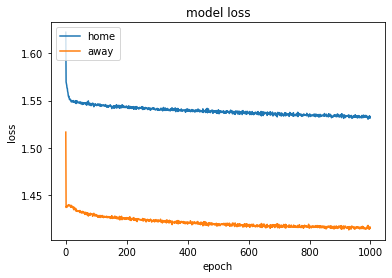

In [24]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['layer3_loss'])
plt.plot(history.history['layer3_1_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['home', 'away'], loc='upper left')
plt.show()

dict_keys(['loss', 'layer3_loss', 'layer3_1_loss', 'layer3_acc', 'layer3_1_acc'])


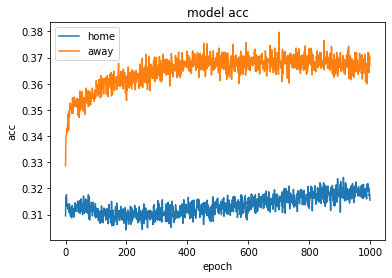

In [25]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['layer3_acc'])
plt.plot(history.history['layer3_1_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['home', 'away'], loc='upper left')
plt.show()

In [26]:
y_train_pred = model.predict(train_X02)
y_test_pred = model.predict(test_X02)

In [27]:
def pred_goal(arr, team):
    a=0
    retVal=np.empty((arr[0].size+1))
    games = int(arr[team].size / arr[team][1].size)
    for i in range(0, games):
        for j in range(0, (arr[team][i].size)):
            if a < arr[team][i][j]:
                a = arr[team][i][j]
                retVal[i] = j
        a = 0
    return retVal
        

In [28]:
predHome = pred_goal(y_test_pred, 0)
predAway = pred_goal(y_test_pred, 1)


In [39]:
for i in range(0,predHome.size):
    if predHome[i] > 1: 
        print(predHome[i])

2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
5.0
2.0
2.0
2.0
2.0
4.0
4.0


In [29]:
def degree_diff(yoriginal,ypred):
    val = abs(yoriginal - ypred)
    switcher = {
        0: 1, # yoriginal = ypred
        1: 0.8, # diff of 1. Exple original 1 predicted 2 => 0.75
        2: 0.6,
        3: 0.4,
        4: 0.2, # diff of 4. Exple original 0 predicted 4
        5: 0
    }
    return switcher.get(val, 0)

In [30]:
quality_model_home_goals=0

for valorg,valpred in zip(yout1,predHome):
    quality_model_home_goals += degree_diff(valorg,valpred)
    
quality_model_home_goals = quality_model_home_goals / len(yout1)
print ("Quality model home goals TRAIN", quality_model_home_goals)

Quality model home goals TRAIN 0.75198863636364


In [31]:
quality_model_away_goals=0

for valorg,valpred in zip(yout2,predAway):
    quality_model_away_goals += degree_diff(valorg,valpred)
    
quality_model_away_goals = quality_model_away_goals / len(yout2)
print ("Quality model away goals TRAIN", quality_model_away_goals)

Quality model away goals TRAIN 0.8096590909090935


In [32]:
final_quality = (quality_model_home_goals + quality_model_away_goals)/2
final_quality

0.7808238636363667